In [1]:
# Simulates traffic flow evolution using finite volume under various fundamental diagrams
#
# Dawson Do, <daws@berkeley.edu>

using PyPlot, PyCall

In [2]:
function plotSpaceTime(t, x, allu)
    umat = reduce(hcat,allu)
    
    """
    # contour lines
    
    cs = contour(t,x,umat,levels = 0:0.1:1,colors="k",linewidths = 0.5)
    clabel(cs)
    """
    
    cf = contourf(t,x,umat,levels = 0:0.001:1);
    
    xlabel(L"t")
    ylabel(L"x\quad→")
    cb = colorbar(ticks=0:0.1:1);
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel(L"k"*" (density)",rotation=270)
end

plotSpaceTime (generic function with 1 method)

In [3]:
function plotFD()
    k = 0:0.001:1;
    
    plot(k,f.(k;fd="triang"),label="Triangular")
    plot(k,f.(k;fd="trapez"),label="Trapezoidal")
    plot(k,f.(k;fd="greens"),label="Greenshields")
    
    plot([0, 0.5, 1],[0, 0.25, 0],"o")
    annotate.(["A","B","C"],[[0.025,0],[0.525,0.25],[1.025,0]])
    
    title("Fundamental Diagrams");
    xlabel(L"k"*" (density)")
    ylabel(L"q"*" (flow)")
    legend()
end

plotFD (generic function with 1 method)

In [4]:
"""
frho = f(rho)

returns flow given density

choose among three FDs: triangular, trapezoidal, greenshields
"""
function f(rho; fd="triang")    
    
    # triangular FD
    if fd == "triang"
        if rho < 1/2
            frho = 1/2*rho
        else
            frho = 1/2*(1-rho)
        end  
    
    # trapezoidal FD
    elseif fd == "trapez"
        
        if rho < 1/2
            frho = 1/2*rho
        elseif rho < 13/16
            frho = 1/5*(7/4-rho)
        else
            frho = (1-rho)
        end
        
    # Greenshields FD
    elseif fd == "greens"
    
        frho = rho*(1-rho)
        
    end
    
    return frho
end

f

In [5]:
"""
t,x,allu = traffic()

uses finite volume method to simulate traffic state evolution
fixed to the domain x ∈ [-0.5,0.5]

parameters
m: the number of partitions
T: end time (i.e. t ∈ [0,T])
kmul: multiplier for CFL condition
"""
function traffic(m=200; T=2, kmul=0.95, fd="triang")
    
    ## params based on FDs
    if fd == "triang"
        rhom = 1.0
        umax = 0.5
        rhoc = 0.5
    elseif fd == "trapez"
        rhom = 1.0
        umax = 1.0
        rhoc = 0.5
    elseif fd == "greens"
        rhom = 1.0
        umax = 1.0
        rhoc = 0.5
    end
        
    L = 1
    
    # Discretization
    h = L / m
    
    ## m midpoints of the domain of m+1 cells
    x = L .* (collect(1:m).-0.5) ./ m .- 0.5
    
    k = kmul*h/umax
    N = ceil(Int, T/k)
    
    ## initial density
    ## u = rhoL = 0.25 when x < 0
    ## u = 0           when x > 0
    
    rhoL = 0.25
    
    u = @. rhoL * Float64(x<0)
    
    allu = [copy(u)]
    
    for it = 1:N
        
        F = zeros(m) # represents F_i+1/2
        
        for i = 1:m-1
            if u[i] < u[i+1]
                F[i] = min(f(u[i];fd),f(u[i+1];fd))
            elseif u[i+1] < rhoc && rhoc < u[i]
                F[i] = f(rhoc)
            else
                F[i] = max(f(u[i];fd),f(u[i+1];fd))
            end
        end
        
        ## traffic light turns red every other unit time interval
        ## i.e. red during 0-1, 2-3, etc.
        if mod(floor(it*k),2) == 0
            F[ceil(Int, m/2)] = 0
        end
        
        Fp = [F[1:end-1];f(u[end];fd)] # frozen boundary outflow
        Fm = [f(u[1];fd);F[1:end-1]]     # frozen boundary inflow
        
        @. u -= k/h * (Fp - Fm) 
        
        push!(allu, copy(u)) # Save numerical solution
    end
    
    t = 0:T/(size(allu)[1]-1):T
    
    return t,x,allu
end

traffic

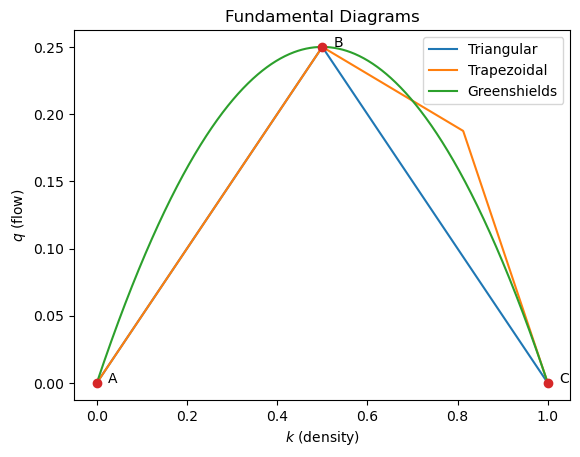

In [6]:
plotFD();

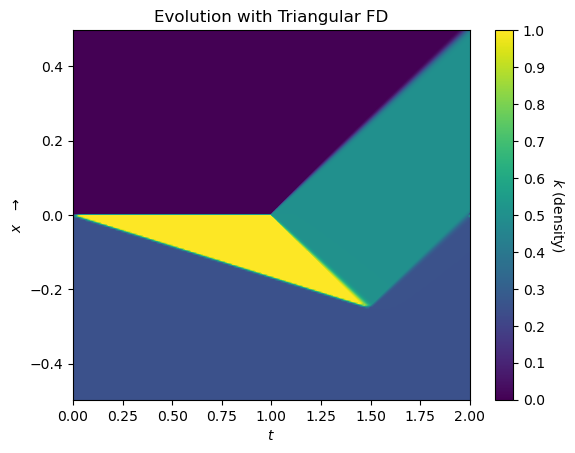

In [7]:
t,x,allu=traffic(;fd="triang");
plotSpaceTime(t,x,allu);
title("Evolution with Triangular FD");

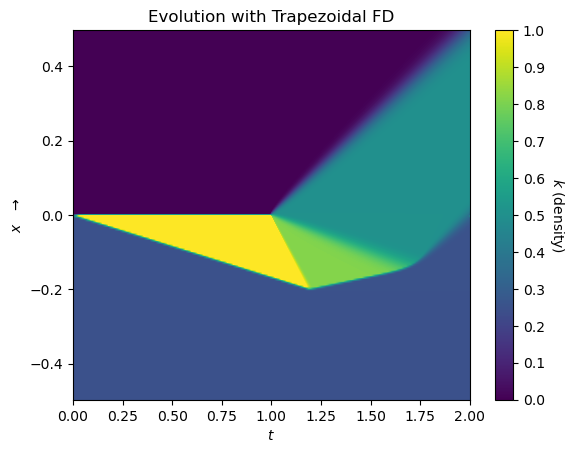

In [8]:
t,x,allu=traffic(;fd="trapez");
plotSpaceTime(t,x,allu);
title("Evolution with Trapezoidal FD");

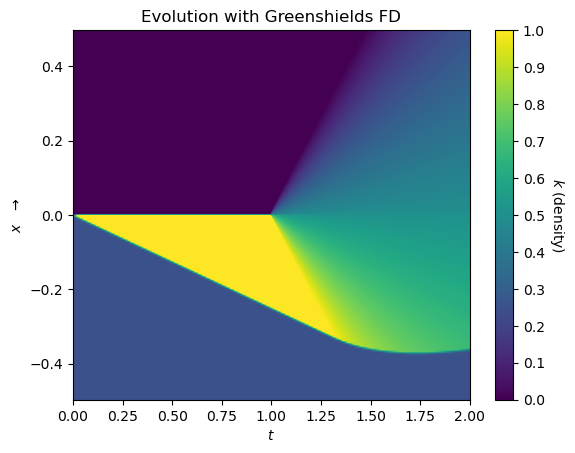

In [9]:
t,x,allu=traffic(;fd="greens");
plotSpaceTime(t,x,allu);
title("Evolution with Greenshields FD");